In [444]:
#load packages
import pandas as pd
import numpy as np
import optuna
import xgboost as xgb
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from math import sqrt, atan2, degrees, pi, atan
from sklearn.model_selection import cross_val_score, KFold
from sklearn.metrics import mean_squared_error
from scipy.stats import gaussian_kde
from plottable import Table

In [2]:
#load all pitches since 2015
csv_file_path = '~/baseball-and-stuff/baseball/all_pitches.csv'

df = pd.read_csv(csv_file_path)

/var/folders/l7/wzwhjfv129l1wmlklwpt_j_r0000gn/T/ipykernel_73703/1455702520.py:4: DtypeWarning: Columns (44) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv(csv_file_path)


In [3]:
df = df[df['game_year'] >= 2023]

In [4]:
def calculate_VRA(vy0, ay, release_extension, vz0, az):
    vy_s = -np.sqrt(vy0**2 - 2 * ay * (60.5 - release_extension - 50))
    t_s = (vy_s - vy0) / ay
    vz_s = vz0 - az * t_s
    VRA = -np.arctan(vz_s / vy_s) * (180 / np.pi)
    return VRA

def calculate_HRA(vy0, ay, release_extension, vx0, ax):
    vy_s = -np.sqrt(vy0**2 - 2 * ay * (60.5 - release_extension - 50))
    t_s = (vy_s - vy0) / ay
    vx_s = vx0 - ax * t_s
    HRA = -np.arctan(vx_s / vy_s) * (180 / np.pi)
    return HRA

df['VRA'] = df.apply(lambda x: calculate_VRA(x['vy0'], x['ay'], x['release_extension'], x['vz0'], x['az']), axis=1)
df['HRA'] = df.apply(lambda x: calculate_HRA(x['vy0'], x['ay'], x['release_extension'], x['vx0'], x['ax']), axis=1)

In [5]:
def calculate_approach_angles(row):
    yf = 17/12
    ay = row['ay']
    vy0 = row['vy0']
    vz0 = row['vz0']
    az = row['az']
    vx0 = row['vx0']
    ax = row['ax']

    vy_f = -np.sqrt(vy0**2 - (2 * ay * (50 - yf)))
    t = (vy_f - vy0) / ay
    vz_f = vz0 + (az * t)
    vaa_rad = atan2(vz_f, vy_f)
    vaa_deg = (180+degrees(vaa_rad))*-1

    vx_f = vx0 + (ax * t)
    haa_deg = -np.arctan(vx_f / vy_f) * (180 / np.pi)

    return pd.Series([vaa_deg, haa_deg, t, vy_f])

df[['VAA', 'HAA', 't', 'vy_f']] = df.apply(calculate_approach_angles, axis=1)

In [6]:
df = df.dropna(subset=['VRA', 'HRA', 'VAA', 'HAA', 'pitch_type', 'game_year', 'pitcher', 'stand'])

features = ['VRA', 'HRA', 'VAA', 'HAA']

for feature in features:
    df[f'{feature}_KDE'] = float('nan')

grouped = df.groupby(['game_year', 'pitcher', 'stand'])

def compute_group_kdes(group, features):
    results = {feature: {} for feature in features}
    for feature in features:
        for pitch_type in group['pitch_type'].unique():
            subset = group[group['pitch_type'] != pitch_type]
            if len(subset) >= 5:
                kde = gaussian_kde(subset[feature])
                results[feature][pitch_type] = kde
            else:
                results[feature][pitch_type] = None
    return results

for _, group in grouped:
    kdes = compute_group_kdes(group, features)
    
    for idx, row in group.iterrows():
        for feature in features:
            kde = kdes[feature].get(row['pitch_type'])
            if kde is not None:
                df.loc[idx, f'{feature}_KDE'] = kde(row[feature])[0]

In [436]:
kde_df = df.groupby(['pitcher', 'player_name', 'pitch_type', 'game_year']).agg(
    VRA=('VRA', 'mean'),
    VRA_KDE=('VRA_KDE', 'mean'),
    VAA=('VAA', 'mean'),    
    VAA_KDE=('VAA_KDE', 'mean'),
    HRA=('HRA', 'mean'),
    HRA_KDE=('HRA_KDE', 'mean'),
    HAA=('HAA', 'mean'),    
    HAA_KDE=('HAA_KDE', 'mean'),
    n=('VRA', 'size')
).reset_index()

In [438]:
kde_df[(kde_df['n'] >= 100)].sort_values(by='VRA_KDE', ascending=False).head(10)

,pitcher,player_name,pitch_type,game_year,VRA,VRA_KDE,VAA,VAA_KDE,HRA,HRA_KDE,HAA,HAA_KDE,n
6523,681982,"Anderson, Grant",SI,2024,0.808754,0.523793,-5.765722,0.418699,4.516589,0.168329,1.199350,0.045627,116
6525,681982,"Anderson, Grant",SL,2024,0.993888,0.464360,-5.494100,0.312097,2.805108,0.151936,4.099880,0.044674,198
956,571948,"Milner, Hoby",ST,2024,1.115275,0.456205,-7.070554,0.132270,-3.338912,0.054182,-5.956462,0.018716,343
1209,592866,"Williams, Trevor",SL,2024,-0.410843,0.453051,-7.347721,0.210430,2.024691,0.264149,3.148196,0.152569,144
955,571948,"Milner, Hoby",ST,2023,1.212155,0.452860,-7.071374,0.165478,-3.672627,0.064196,-6.266384,0.012196,340
3631,657044,"Thompson, Ryan",SL,2024,1.579678,0.449401,-5.150874,0.287137,3.360864,0.158627,5.781239,0.023895,251
954,571948,"Milner, Hoby",SI,2024,0.920106,0.449209,-5.609815,0.163333,-6.003266,0.171970,-2.626022,0.139202,334
1207,592866,"Williams, Trevor",SI,2024,-0.572070,0.448445,-6.676329,0.195223,3.200894,0.316320,0.394358,0.109565,129
953,571948,"Milner, Hoby",SI,2023,0.943264,0.447586,-5.833101,0.176929,-5.895610,0.191682,-2.372802,0.125154,305
950,571948,"Milner, Hoby",CH,2024,0.980086,0.446090,-6.373391,0.227173,-5.485550,0.189999,-2.633684,0.192997,143


In [203]:
#find primary fastballs against each handedness
fastballs = ['FF', 'SI', 'FC', 'FA']
df_fb = df[df['pitch_type'].isin(fastballs)]

most_common_fb = df_fb.groupby(['pitcher', 'game_year', 'stand'])['pitch_type'].agg(lambda x: x.mode().iloc[0]).reset_index()
most_common_fb = most_common_fb.rename(columns={'pitch_type': 'most_common_fb'})

df_fb = df_fb.merge(most_common_fb, on=['pitcher', 'game_year', 'stand'], how='left')

df_fb_filtered = df_fb[df_fb['pitch_type'] == df_fb['most_common_fb']]

average_metrics = df_fb_filtered.groupby(['pitcher', 'game_year', 'stand', 'most_common_fb']).agg({
    'release_speed': 'mean',
    'release_pos_x': 'mean',
    'release_pos_z': 'mean',
    'ax': 'mean',
    'az': 'mean'
}).reset_index()

average_metrics = average_metrics.rename(columns={
    'release_speed': 'avg_release_speed',
    'release_pos_x': 'avg_release_pos_x',
    'release_pos_z': 'avg_release_pos_z',
    'ax': 'avg_ax_x',
    'az': 'avg_az_z'
})

average_pos = df.groupby(['pitcher', 'game_year', 'stand']).agg({
    'release_pos_x': 'mean',
    'release_pos_z': 'mean'
}).reset_index()

average_t = df_fb[df_fb['pitch_type'] == df_fb['most_common_fb']].groupby(['pitcher', 'game_year', 'stand', 'most_common_fb']).agg({
    't': 'mean',
}).reset_index()

average_t = average_t.rename(columns={'t': 'avg_t'})

average_pos = average_pos.rename(columns={
    'release_pos_x': 'avg_release_pos_x',
    'release_pos_z': 'avg_release_pos_z'
})

model_df = df.merge(average_pos, on=['pitcher', 'game_year', 'stand'], how='left')

model_df = model_df.merge(average_t, on=['pitcher', 'game_year', 'stand'], how='left')

In [205]:
#label 0 if fastball, 1 if breaker, 2 if offspeed
def assign_pitch_group(row):
    if row['pitch_type'] in ['FF', 'SI', 'FA'] or (row['pitch_type'] == 'FC' and row['most_common_fb'] == 'FC'):
        return 0
    elif row['pitch_type'] in ['SL', 'CU', 'KC', 'ST', 'SV'] or (row['pitch_type'] == 'FC' and row['most_common_fb'] != 'FC'):
        return 1
    elif row['pitch_type'] in ['CH', 'FS', 'KN', 'EP', 'FO', 'SC']:
        return 2
    else:
        return None

model_df['pitch_group'] = model_df.apply(assign_pitch_group, axis=1)

In [206]:
#integer encode platoon state
conditions = [
    (model_df['stand'] == 'L') & (model_df['p_throws'] == 'L'),
    (model_df['stand'] == 'L') & (model_df['p_throws'] == 'R'),  
    (model_df['stand'] == 'R') & (model_df['p_throws'] == 'L'),  
    (model_df['stand'] == 'R') & (model_df['p_throws'] == 'R') 
]

values = [0, 1, 2, 3]

model_df['platoon_state'] = np.select(conditions, values)

#integer encode count
count_mapping = {
    (0, 0): 0,
    (0, 1): 1,
    (0, 2): 2,
    (1, 0): 3,
    (1, 1): 4,
    (1, 2): 5,
    (2, 0): 6,
    (2, 1): 7,
    (2, 2): 8,
    (3, 0): 9,
    (3, 1): 10,
    (3, 2): 11
}

model_df['count'] = model_df[['balls', 'strikes']].apply(tuple, axis=1).map(count_mapping)

In [207]:
#find average run value for each event so we can ignore game state leverage
description_avg = model_df.groupby('description')['delta_run_exp'].mean().reset_index()
description_avg = description_avg.rename(columns={'delta_run_exp': 'avg_run_value_desc'})

events_avg = model_df[model_df['description'] == 'hit_into_play'].groupby('events')['delta_run_exp'].mean().reset_index()
events_avg = events_avg.rename(columns={'delta_run_exp': 'avg_run_value_event'})

model_df = model_df.merge(description_avg, on='description', how='left')

model_df = model_df.merge(events_avg, on='events', how='left', suffixes=('', '_event'))

model_df['run_value'] = model_df.apply(lambda row: row['avg_run_value_event'] if row['description'] == 'hit_into_play' else row['avg_run_value_desc'], axis=1)

model_df = model_df.drop(columns=['avg_run_value_desc', 'avg_run_value_event'])

In [208]:
#features
features = ['release_speed', 'release_pos_x', 'release_pos_z', 'platoon_state', 'count', 'game_year', 'pitch_group', 
            'ax', 'az', 'plate_x', 'plate_z', 'release_extension', 'release_spin_rate', 'spin_axis', 'avg_release_pos_x', 
            'avg_release_pos_z', 'HRA_KDE', 'VRA_KDE', 'VAA_KDE', 'HAA_KDE', 'avg_t']

#target variable
target = 'run_value'

In [211]:
#drop NAs
model_df = model_df.dropna(subset=features + [target])

#set X and y
X = model_df[features]
y = model_df[target]

#define objective function
def objective(trial):
    param = {
        "verbosity": 0,
        "objective": "reg:squarederror",
        "booster": "gbtree",
        "lambda": trial.suggest_float("lambda", 1e-8, 1.0, log=True),
        "alpha": trial.suggest_float("alpha", 1e-8, 1.0, log=True),
        "n_estimators": trial.suggest_int("n_estimators", 100, 1000),
        "max_depth": trial.suggest_int("max_depth", 3, 9),
        "eta": trial.suggest_float("eta", 0.01, 0.3, log=True),
        "gamma": trial.suggest_float("gamma", 1e-8, 1.0, log=True),
        "grow_policy": trial.suggest_categorical("grow_policy", ["depthwise", "lossguide"]),
        "subsample": trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree": trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "min_child_weight": trial.suggest_int("min_child_weight", 1, 10),
    }
    
    #define XGBRegressor and use rmse as eval metric
    model = xgb.XGBRegressor(**param, eval_metric='rmse', use_label_encoder=False)

    #set up KFold CV
    kf = KFold(n_splits=5, shuffle=True, random_state=13)
    rmse_scores = cross_val_score(model, X, y, scoring='neg_root_mean_squared_error', cv=kf, n_jobs=-1)
    
    return -np.mean(rmse_scores)

#initialize Optuna study
study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=50)

print("Best hyperparameters:", study.best_params)
best_params = study.best_params

#train final model with best params
quality_model = xgb.XGBRegressor(**best_params)
quality_model.fit(X, y)

[I 2024-11-26 18:54:45,945] A new study created in memory with name: no-name-ede47002-6f8f-4c2a-8081-80db131f5400
[I 2024-11-26 18:55:28,762] Trial 0 finished with value: 0.20714854450723053 and parameters: {'lambda': 0.08887504063138214, 'alpha': 7.086739335742478e-06, 'n_estimators': 107, 'max_depth': 8, 'eta': 0.03455332746909335, 'gamma': 1.5391251483697838e-05, 'grow_policy': 'depthwise', 'subsample': 0.9278750686362812, 'colsample_bytree': 0.8278846958765849, 'min_child_weight': 1}. Best is trial 0 with value: 0.20714854450723053.
[I 2024-11-26 18:59:43,351] Trial 1 finished with value: 0.20789716488053372 and parameters: {'lambda': 0.8828490277374206, 'alpha': 0.043448115437507234, 'n_estimators': 838, 'max_depth': 9, 'eta': 0.0589799421578398, 'gamma': 1.2804288993236587e-06, 'grow_policy': 'lossguide', 'subsample': 0.9157893633071149, 'colsample_bytree': 0.7139019705903507, 'min_child_weight': 3}. Best is trial 0 with value: 0.20714854450723053.
[I 2024-11-26 19:00:11,554] Tri

Best hyperparameters: {'lambda': 0.0001915819767771648, 'alpha': 0.9924428515900598, 'n_estimators': 755, 'max_depth': 9, 'eta': 0.014370577769687417, 'gamma': 0.0007387728521780975, 'grow_policy': 'lossguide', 'subsample': 0.864323630119067, 'colsample_bytree': 0.8433199541275067, 'min_child_weight': 5}


XGBRegressor(alpha=0.9924428515900598, base_score=None, booster=None,
             callbacks=None, colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8433199541275067, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eta=0.014370577769687417, eval_metric=None, feature_types=None,
             gamma=0.0007387728521780975, grow_policy='lossguide',
             importance_type=None, interaction_constraints=None,
             lambda=0.0001915819767771648, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=9, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=755, ...)

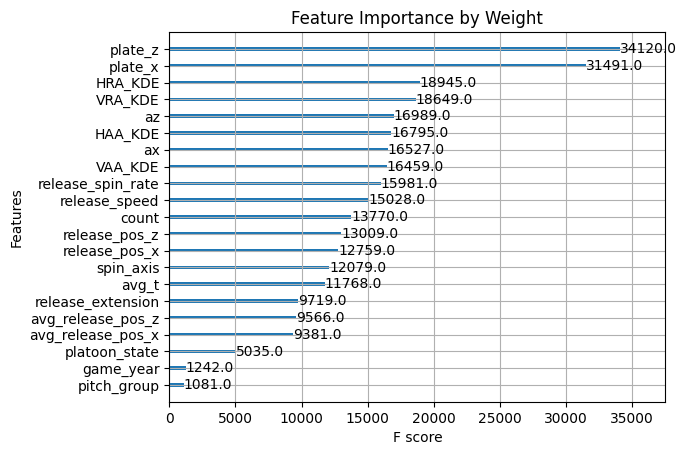

In [212]:
xgb.plot_importance(quality_model.get_booster(), importance_type='weight', title="Feature Importance by Weight")
plt.show()

In [213]:
explainer = shap.Explainer(quality_model)

In [214]:
df2024 = model_df[model_df['game_date'] >= '2024-03-01']

In [215]:
df2024['predicted_run_value'] = quality_model.predict(df2024[features])

/var/folders/l7/wzwhjfv129l1wmlklwpt_j_r0000gn/T/ipykernel_73703/2514536343.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2024['predicted_run_value'] = quality_model.predict(df2024[features])


In [261]:
shap_values = explainer(df2024[features])

excluded_features = ['VRA_KDE', 'HRA_KDE', 'VAA_KDE', 'HAA_KDE', 'avg_t', 'avg_release_pos_z', 'avg_release_pos_x']
excluded_indices = [df2024[features].columns.get_loc(col) for col in excluded_features]

included_indices = [i for i in range(len(features)) if i not in excluded_indices]

excluded_shap_values = {}

for col, idx in zip(excluded_features, excluded_indices):
    excluded_shap_values[col] = shap_values.values[:, idx]

for col, shap_value in excluded_shap_values.items():
    df2024[f'{col}_shap'] = shap_value

excluded_shap_sum = sum(excluded_shap_values[col] for col in excluded_shap_values)
adjusted_predictions = shap_values.base_values + shap_values.values[:, included_indices].sum(axis=1)

original_predictions = quality_model.predict(df2024[features])
tunnel_boost_preds = original_predictions - adjusted_predictions

df2024['tunnel_boost'] = tunnel_boost_preds + excluded_shap_sum

/var/folders/l7/wzwhjfv129l1wmlklwpt_j_r0000gn/T/ipykernel_73703/1780600197.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2024[f'{col}_shap'] = shap_value
/var/folders/l7/wzwhjfv129l1wmlklwpt_j_r0000gn/T/ipykernel_73703/1780600197.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2024[f'{col}_shap'] = shap_value
/var/folders/l7/wzwhjfv129l1wmlklwpt_j_r0000gn/T/ipykernel_73703/1780600197.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using

In [295]:
shap_columns = ['VRA_KDE_shap', 'VAA_KDE_shap', 'HRA_KDE_shap', 'HAA_KDE_shap', 'avg_t_shap']

df2024['tunnel_boost'] = df2024[shap_columns].sum(axis=1)

/var/folders/l7/wzwhjfv129l1wmlklwpt_j_r0000gn/T/ipykernel_73703/554812039.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2024['tunnel_boost'] = df2024[shap_columns].sum(axis=1)


In [406]:
df2024['x_tunnel'] = df2024['HRA_KDE_shap'] + df2024['HAA_KDE_shap']
df2024['y_tunnel'] = df2024['avg_t_shap']
df2024['z_tunnel'] = df2024['VRA_KDE_shap'] + df2024['VAA_KDE_shap']
df2024['arm_angle_tunnel'] = df2024['avg_release_pos_x_shap'] + df2024['avg_release_pos_z_shap']

df2024['shape_tunnel'] = df2024['x_tunnel'] + df2024['z_tunnel']

/var/folders/l7/wzwhjfv129l1wmlklwpt_j_r0000gn/T/ipykernel_73703/4024535167.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2024['x_tunnel'] = df2024['HRA_KDE_shap'] + df2024['HAA_KDE_shap']
/var/folders/l7/wzwhjfv129l1wmlklwpt_j_r0000gn/T/ipykernel_73703/4024535167.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df2024['y_tunnel'] = df2024['avg_t_shap']
/var/folders/l7/wzwhjfv129l1wmlklwpt_j_r0000gn/T/ipykernel_73703/4024535167.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy 

In [446]:
grouped_df = (
    df2024.groupby(['pitcher', 'player_name', 'pitch_type'])
    .agg(tunnel_boost_mean=('tunnel_boost', 'mean'),
        VRA_KDE_mean=('VRA_KDE', 'mean'),
        HRA_KDE_mean=('HRA_KDE', 'mean'),
        VAA_KDE_mean=('VAA_KDE', 'mean'),
        HAA_KDE_mean=('HAA_KDE', 'mean'),
        avg_t_mean=('avg_t', 'mean'),
        release_pos_z=('release_pos_z', 'mean'),
        release_pos_x=('release_pos_x', 'mean'),
        avg_release_pos_z=('avg_release_pos_z', 'mean'),
        avg_release_pos_x=('avg_release_pos_x', 'mean'),
        VRA_KDE_shap=('VRA_KDE_shap', 'mean'),
        HRA_KDE_shap=('HRA_KDE_shap', 'mean'),
        VAA_KDE_shap=('VAA_KDE_shap', 'mean'),
        HAA_KDE_shap=('HAA_KDE_shap', 'mean'),
        avg_t_shap=('avg_t_shap', 'mean'),
        avg_release_pos_z_shap=('avg_release_pos_z_shap', 'mean'),
        avg_release_pos_x_shap=('avg_release_pos_x_shap', 'mean'),
        x_tunnel=('x_tunnel', 'mean'),
        y_tunnel=('y_tunnel', 'mean'),
        z_tunnel=('z_tunnel', 'mean'),
        arm_angle_tunnel=('arm_angle_tunnel', 'mean'),
        shape_tunnel=('shape_tunnel', 'mean'),
        tunnel_boost=('tunnel_boost', 'mean'),
        avg_run_value=('run_value', 'mean'),
        pred_run_value_mean=('predicted_run_value', 'mean'),
        n=('tunnel_boost', 'size')).reset_index()
)

total_pitches = df2024.groupby(['pitcher', 'player_name'])['tunnel_boost'].size().reset_index(name='total_n')

grouped_df = grouped_df.merge(total_pitches, on=['pitcher', 'player_name'])

grouped_df['usage_rate'] = grouped_df['n'] / grouped_df['total_n']
grouped_df['rv_residual'] = grouped_df['avg_run_value'] - grouped_df['pred_run_value_mean']

grouped_df[(grouped_df['n'] >= 250)].sort_values(by='tunnel_boost_mean', ascending=True).head(10)

,pitcher,player_name,pitch_type,tunnel_boost_mean,VRA_KDE_mean,HRA_KDE_mean,VAA_KDE_mean,HAA_KDE_mean,avg_t_mean,release_pos_z,...,z_tunnel,arm_angle_tunnel,shape_tunnel,tunnel_boost,avg_run_value,pred_run_value_mean,n,total_n,usage_rate,rv_residual
1987,664854,"Helsley, Ryan",SL,-0.011406,0.184727,0.388640,0.042435,0.248999,0.350233,6.119822,...,-0.001077,-0.000146,-0.002365,-0.011406,-0.033004,-0.019392,450,931,0.483351,-0.013612
3469,694973,"Skenes, Paul",SI,-0.010451,0.319413,0.271129,0.167392,0.191710,0.352511,5.646186,...,-0.001108,0.000417,-0.001809,-0.010451,-0.030060,-0.018103,603,2125,0.283765,-0.011956
1743,662253,"Muñoz, Andrés",SL,-0.008846,0.279194,0.189121,0.065385,0.065541,0.353776,5.191384,...,-0.001982,-0.001221,-0.001343,-0.008846,-0.021381,-0.010403,448,951,0.471083,-0.010978
1729,661395,"Duran, Jhoan",FS,-0.008267,0.270679,0.296422,0.082963,0.215572,0.346619,5.931155,...,-0.000158,0.000741,-0.000947,-0.008267,-0.009357,-0.013679,277,881,0.314415,0.004322
1730,661403,"Clase, Emmanuel",FC,-0.008263,0.241098,0.326638,0.126967,0.241958,0.348720,6.061908,...,0.000644,-0.000655,0.000371,-0.008263,-0.032537,-0.015219,765,983,0.778230,-0.017317
2107,666808,"Doval, Camilo",SL,-0.008114,0.290468,0.230856,0.042684,0.176688,0.350170,5.501565,...,-0.001861,0.000108,-0.001071,-0.008114,-0.013620,-0.010106,556,1090,0.510092,-0.003515
2898,679885,"Martinez, Justin",SL,-0.007817,0.283566,0.253424,0.168981,0.084145,0.347603,6.279764,...,0.000247,0.000292,-0.000187,-0.007817,-0.027627,-0.018816,254,1177,0.215803,-0.008812
923,621237,"Alvarado, José",FC,-0.007714,0.272923,0.340357,0.086807,0.105968,0.356386,6.694634,...,-0.000924,-0.000902,-0.002975,-0.007714,-0.004829,0.001398,410,1016,0.403543,-0.006227
2896,679885,"Martinez, Justin",FS,-0.007072,0.246099,0.274492,0.111846,0.227630,0.347797,6.362840,...,0.001137,0.001665,0.000965,-0.007072,-0.013871,-0.003897,257,1177,0.218352,-0.009975
692,605483,"Snell, Blake",CH,-0.006648,0.257199,0.283703,0.059330,0.128442,0.363828,6.492894,...,-0.001690,-0.000039,-0.002786,-0.006648,-0.016750,-0.021835,311,1773,0.175409,0.005084


In [445]:
tunnel_boost_r = df2024[df2024['stand'] == 'R'].groupby(['pitcher', 'player_name', 'pitch_type'])['tunnel_boost'].mean().reset_index(name='tunnel_boost_R')
tunnel_boost_l = df2024[df2024['stand'] == 'L'].groupby(['pitcher', 'player_name', 'pitch_type'])['tunnel_boost'].mean().reset_index(name='tunnel_boost_L')

tunnel_diff_df = tunnel_boost_r.merge(tunnel_boost_l, on=['pitcher', 'player_name', 'pitch_type'], how='outer')
tunnel_diff_df['tunnel_boost_diff'] = tunnel_diff_df['tunnel_boost_R'] - tunnel_diff_df['tunnel_boost_L']

n_r = df2024[df2024['stand'] == 'R'].groupby(['pitcher', 'player_name', 'pitch_type'])['tunnel_boost'].size().reset_index(name='n_R')
n_l = df2024[df2024['stand'] == 'L'].groupby(['pitcher', 'player_name', 'pitch_type'])['tunnel_boost'].size().reset_index(name='n_L')

tunnel_diff_df = tunnel_diff_df.merge(n_r, on=['pitcher', 'player_name', 'pitch_type'], how='left')
tunnel_diff_df = tunnel_diff_df.merge(n_l, on=['pitcher', 'player_name', 'pitch_type'], how='left')

tunnel_diff_df[(tunnel_diff_df['n_R'] >= 100) & (tunnel_diff_df['n_L'] >= 100)].sort_values(by='tunnel_boost_diff').head(10)

,pitcher,player_name,pitch_type,tunnel_boost_R,tunnel_boost_L,tunnel_boost_diff,n_R,n_L
305,547973,"Chapman, Aroldis",FF,-0.007267,0.000316,-0.007583,265.0,121.0
2416,670059,"Holderman, Colin",ST,-0.003555,0.003616,-0.007171,223.0,187.0
1796,663485,"Sands, Cole",FF,-0.002490,0.004101,-0.006591,185.0,140.0
1795,663485,"Sands, Cole",FC,-0.003624,0.002137,-0.005762,179.0,163.0
1008,622491,"Castillo, Luis",SI,-0.001587,0.003729,-0.005315,358.0,153.0
343,570632,"Ureña, José",SI,-0.002784,0.002195,-0.004979,420.0,299.0
204,542881,"Anderson, Tyler",FF,-0.000447,0.004106,-0.004553,932.0,223.0
455,592155,"Booser, Cam",FC,-0.002835,0.001702,-0.004537,143.0,103.0
556,595014,"Treinen, Blake",ST,-0.002666,0.001598,-0.004265,176.0,108.0
3205,686563,"Cannon, Jonathan",SI,0.002279,0.006473,-0.004194,377.0,190.0


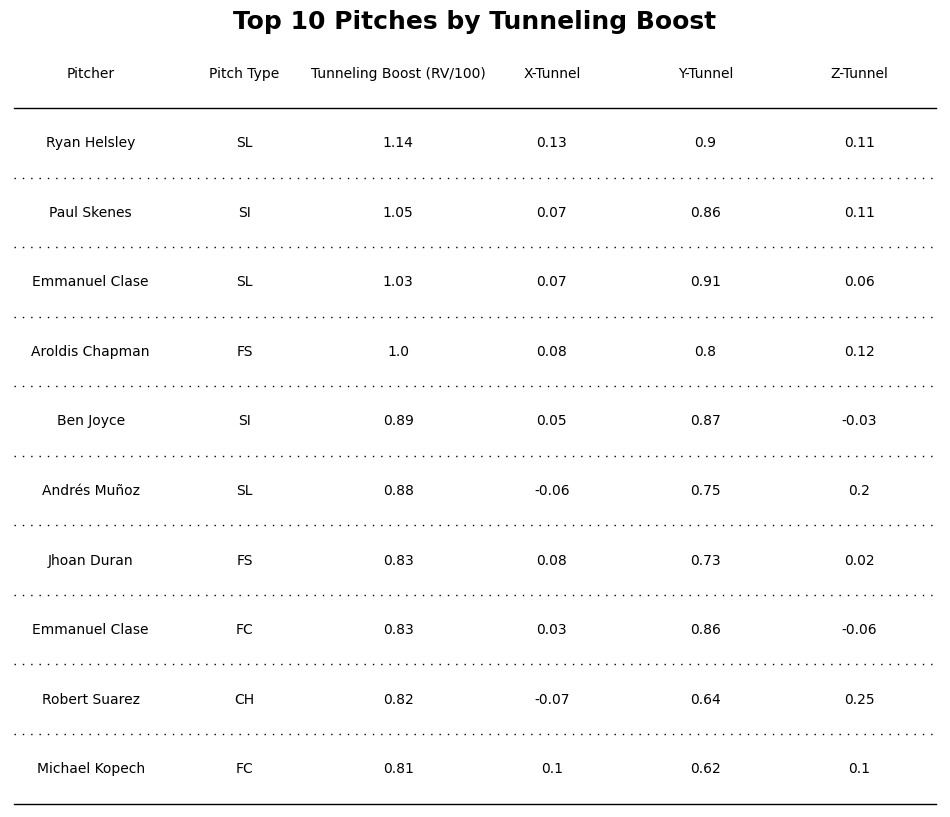

In [447]:
leaderboard_df = grouped_df[(grouped_df['n'] >= 50)].sort_values(by='tunnel_boost', ascending=True)[['player_name', 'pitch_type', 'tunnel_boost',
                                                                                                           'x_tunnel', 'y_tunnel', 'z_tunnel']].head(10)

leaderboard_df['tunnel_boost'] = (leaderboard_df['tunnel_boost'] * -100).round(2)
leaderboard_df['x_tunnel'] = (leaderboard_df['x_tunnel'] * -100).round(2)
leaderboard_df['y_tunnel'] = (leaderboard_df['y_tunnel'] * -100).round(2)
leaderboard_df['z_tunnel'] = (leaderboard_df['z_tunnel'] * -100).round(2)

leaderboard_df = leaderboard_df.rename(columns={ 
    'player_name': 'Pitcher',
    'pitch_type': 'Pitch Type',
    'tunnel_boost': 'Tunneling Boost (RV/100)',
    'x_tunnel': 'X-Tunnel',
    'y_tunnel': 'Y-Tunnel',
    'z_tunnel': 'Z-Tunnel'
})

leaderboard_df['Pitcher'] = leaderboard_df['Pitcher'].apply(lambda x: ' '.join(x.split(', ')[::-1]))

leaderboard_df.set_index('Pitcher', inplace=True)

fig, ax = plt.subplots(figsize=(12, 10))
ax.axis('off')

table = Table(
    leaderboard_df,
    row_dividers=True,
    footer_divider=True,
    textprops={"fontsize": 10, "ha": "center"},
    row_divider_kw={"linewidth": 1, "linestyle": (0, (1, 5))},
    col_label_divider_kw={"linewidth": 1, "linestyle": "-"},
    column_border_kw={"linewidth": 1, "linestyle": "-"},
)

table.column_border_kw = {
    0: {"linewidth": 2, "linestyle": "-"},  
    1: {"linewidth": 1, "linestyle": "-"},  
    2: {"linewidth": 1, "linestyle": "-"} 
}

plt.title('Top 10 Pitches by Tunneling Boost', fontsize=18, fontweight='bold')
plt.show()


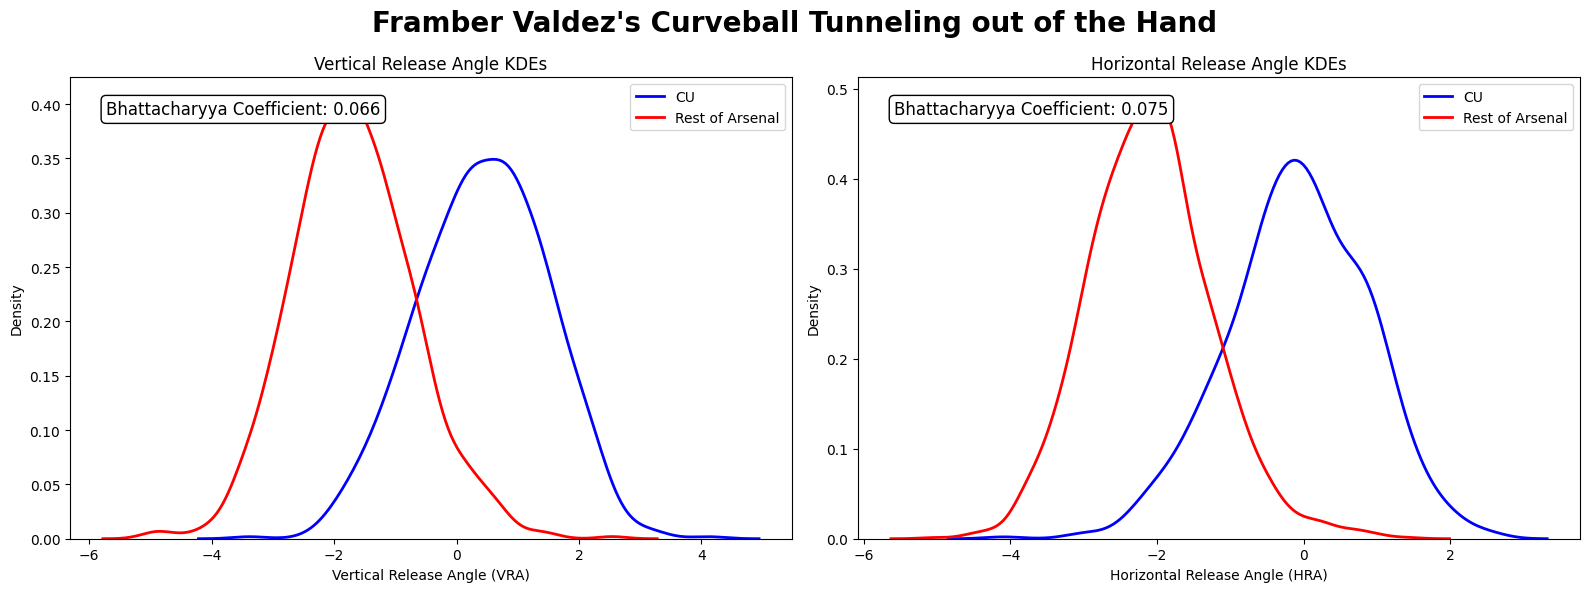

In [449]:
def bhattacharyya_coefficient(data1, data2):
    kde1 = gaussian_kde(data1)
    kde2 = gaussian_kde(data2)

    grid = np.linspace(min(data1.min(), data2.min()), max(data1.max(), data2.max()), 1000)

    kde1_vals = kde1(grid)
    kde2_vals = kde2(grid)

    bc = np.sum(np.sqrt(kde1_vals * kde2_vals)) / len(grid)
    
    return bc

pitcher = 'Valdez, Framber'
pitch = 'CU'

pitcher_df = df2024[df2024['player_name'] == pitcher]
pitcher_df = pitcher_df.dropna(subset=['VRA', 'HRA'])

vra_bc = bhattacharyya_coefficient(pitcher_df[pitcher_df['pitch_type'] == pitch]['VRA'], 
                                   pitcher_df[pitcher_df['pitch_type'] != pitch]['VRA'])

hra_bc = bhattacharyya_coefficient(pitcher_df[pitcher_df['pitch_type'] == pitch]['HRA'], 
                                   pitcher_df[pitcher_df['pitch_type'] != pitch]['HRA'])

fig, axes = plt.subplots(1, 2, figsize=(16, 6))

sns.kdeplot(pitcher_df[pitcher_df['pitch_type'] == pitch]['VRA'], color='blue', label=pitch, lw=2, ax=axes[0])
sns.kdeplot(pitcher_df[pitcher_df['pitch_type'] != pitch]['VRA'], color='red', label="Rest of Arsenal", lw=2, ax=axes[0])
axes[0].set_title(f'Vertical Release Angle KDEs')
axes[0].set_xlabel('Vertical Release Angle (VRA)')
axes[0].set_ylabel('Density')
axes[0].legend()

axes[0].text(0.05, 0.95, f'Bhattacharyya Coefficient: {vra_bc:.3f}', transform=axes[0].transAxes, fontsize=12, 
             verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

sns.kdeplot(pitcher_df[pitcher_df['pitch_type'] == pitch]['HRA'], color='blue', label=pitch, lw=2, ax=axes[1])
sns.kdeplot(pitcher_df[pitcher_df['pitch_type'] != pitch]['HRA'], color='red', label="Rest of Arsenal", lw=2, ax=axes[1])
axes[1].set_title(f'Horizontal Release Angle KDEs')
axes[1].set_xlabel('Horizontal Release Angle (HRA)')
axes[1].set_ylabel('Density')
axes[1].legend()

axes[1].text(0.05, 0.95, f'Bhattacharyya Coefficient: {hra_bc:.3f}', transform=axes[1].transAxes, fontsize=12, 
             verticalalignment='top', bbox=dict(boxstyle="round,pad=0.3", edgecolor="black", facecolor="white"))

plt.suptitle("Framber Valdez's Curveball Tunneling out of the Hand", fontweight='bold', fontsize=20)

plt.tight_layout()

plt.show()

In [450]:
valdez_df = df2024[(df2024['player_name'] == 'Valdez, Framber') &
                   (df2024['VRA'] >= -3) &
                   (df2024['VRA'] <= 1) &
                   (df2024['HRA'] >= -3) &
                   (df2024['HRA'] <= 1)]

In [451]:
valdez_df['in_zone'] = np.where(
    (valdez_df['plate_x'].between(-0.84, 0.84)) & 
    (valdez_df['plate_z'] >= valdez_df['sz_bot'] - 0.01) & 
    (valdez_df['plate_z'] <= valdez_df['sz_top'] + 0.01),
    1, 0
)

/var/folders/l7/wzwhjfv129l1wmlklwpt_j_r0000gn/T/ipykernel_73703/2869922780.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  valdez_df['in_zone'] = np.where(


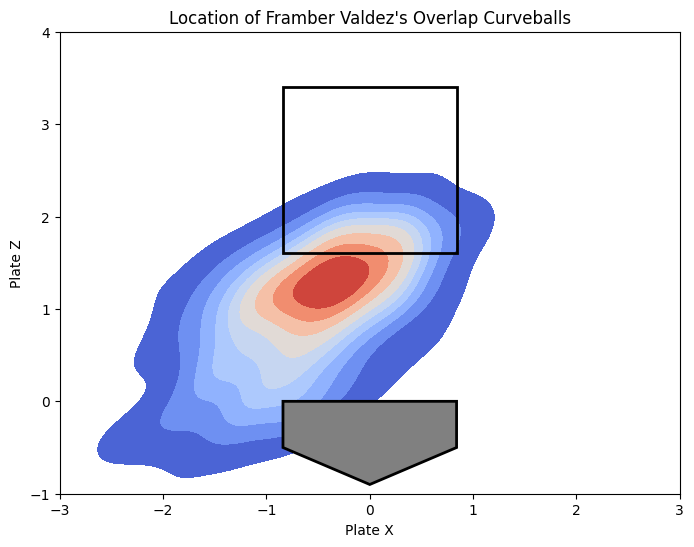

In [453]:
valdez_curveballs = valdez_df[valdez_df['pitch_type'] == 'CU']

plt.figure(figsize=(8, 6))
sns.kdeplot(data=valdez_curveballs, x='plate_x', y='plate_z', cmap='coolwarm', fill=True)

plt.title("Location of Framber Valdez's Overlap Curveballs")
plt.xlabel('Plate X')
plt.ylabel('Plate Z')

plt.xlim(-3, 3)
plt.ylim(-1, 4)

plt.gca().add_patch(plt.Rectangle((-0.84, 1.6), 1.68, 1.8, linewidth=2, edgecolor='black', facecolor='none'))
polygon_coords = [(-0.84, 0), (0.84, 0), (0.84, -0.5), (0, -0.9), (-0.84, -0.5)]
polygon = plt.Polygon(polygon_coords, closed=True, edgecolor='black', facecolor='grey', linewidth=2)
plt.gca().add_patch(polygon)
plt.show()

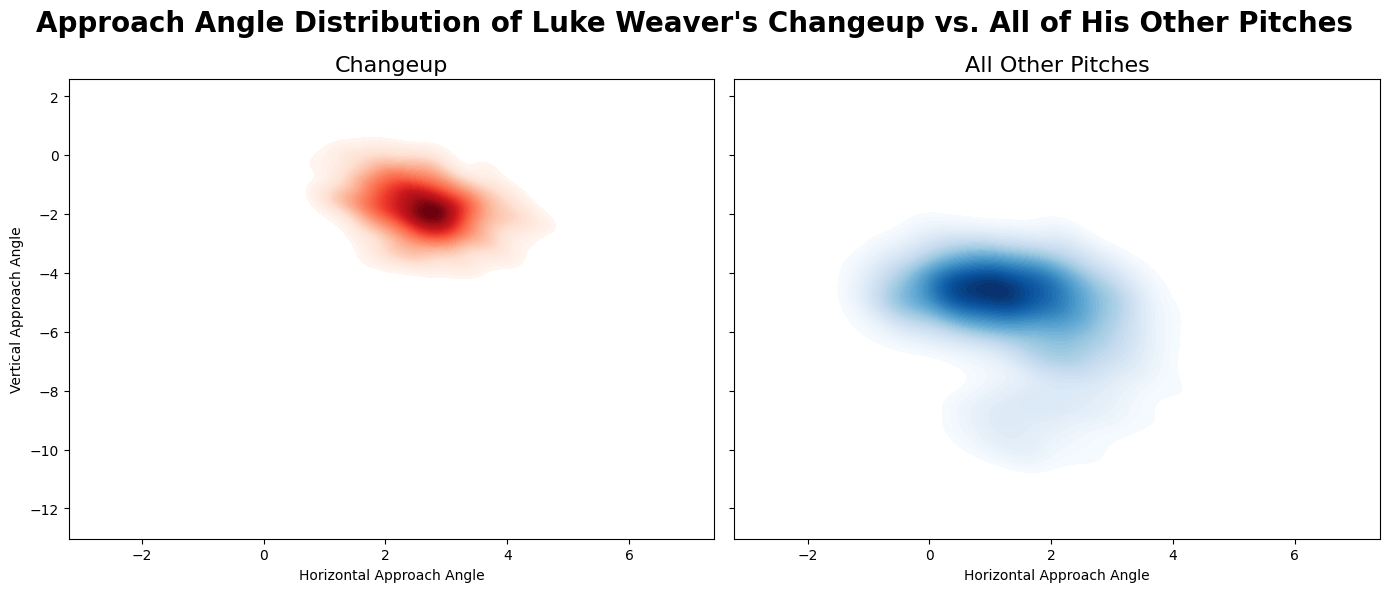

In [455]:
def plot_pitch_heatmaps(df, player_name, pitch_type):
    player_data = df[df['player_name'] == player_name]
    
    selected_pitch = player_data[player_data['pitch_type'] == pitch_type]
    
    other_pitches = player_data[player_data['pitch_type'] != pitch_type]
    
    fig, axes = plt.subplots(1, 2, figsize=(14, 6), sharex=True, sharey=True)
    
    sns.kdeplot(
        x=selected_pitch['HRA'], y=selected_pitch['VRA'],
        fill=True, cmap='Reds', ax=axes[0], levels=50
    )
    axes[0].set_title(f'Changeup', fontsize=16)
    axes[0].set_xlabel('Horizontal Approach Angle')
    axes[0].set_ylabel('Vertical Approach Angle')
    
    sns.kdeplot(
        x=other_pitches['HAA'], y=other_pitches['VAA'],
        fill=True, cmap='Blues', ax=axes[1], levels=50
    )
    axes[1].set_title(f'All Other Pitches', fontsize=16)
    axes[1].set_xlabel('Horizontal Approach Angle')
    axes[1].set_ylabel('Vertical Approach Angle')

    plt.suptitle("Approach Angle Distribution of Luke Weaver's Changeup vs. All of His Other Pitches", fontsize=20, fontweight='bold')

    plt.tight_layout()
    plt.show()

plot_pitch_heatmaps(df, player_name='Weaver, Luke', pitch_type='CH')